In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Rio De Janeiro - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_RJ.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio de-01eiro - value,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Rio De Janeiro - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego
0,2003-1,0.291137,12454.864800,3.675288e+07,254.362,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.773489,0.805095,0.731110,0.804160,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.356512
1,2003-2,0.293538,12574.990185,3.674675e+07,252.842,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.773547,0.804751,0.731248,0.804513,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.350332
2,2003-3,0.295914,12687.426111,3.674063e+07,229.385,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.773606,0.804407,0.731386,0.804866,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.344152
3,2003-4,0.298264,12814.530039,3.673451e+07,243.407,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.773665,0.804063,0.731524,0.805218,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.337971
4,2003-5,0.300588,12915.463832,3.672839e+07,256.535,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.773724,0.803719,0.731662,0.805571,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.331791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,41155.899192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,41127.312621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,41085.437504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,40981.162673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


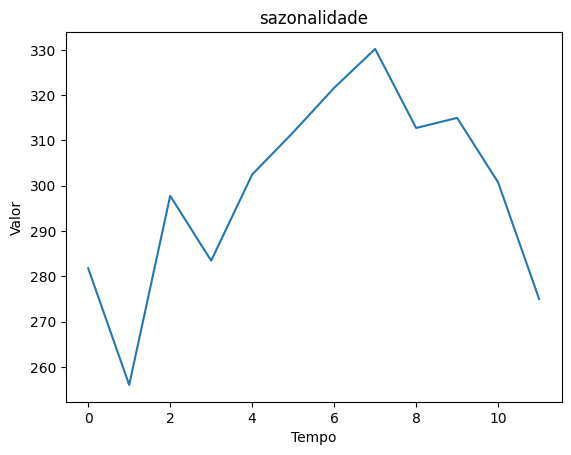

,sazonalidade
sazonalidade,
0,281.787783
1,256.037383
2,297.774940
3,283.460373
4,302.478384
5,311.794884
6,321.608097
7,330.208811
8,312.754725


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio de-01eiro - value,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego,sazonalidade,Rio De Janeiro - Consumo de Cimento (t)
0,2003-1,0.291137,12454.864800,3.675288e+07,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.773489,0.805095,0.731110,0.804160,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.356512,281.787783,254.362
1,2003-2,0.293538,12574.990185,3.674675e+07,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.773547,0.804751,0.731248,0.804513,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.350332,256.037383,252.842
2,2003-3,0.295914,12687.426111,3.674063e+07,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.773606,0.804407,0.731386,0.804866,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.344152,297.774940,229.385
3,2003-4,0.298264,12814.530039,3.673451e+07,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.773665,0.804063,0.731524,0.805218,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.337971,283.460373,243.407
4,2003-5,0.300588,12915.463832,3.672839e+07,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.773724,0.803719,0.731662,0.805571,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.331791,302.478384,256.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,41155.899192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.478384,NaN
245,2023-6,NaN,41127.312621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311.794884,NaN
246,2023-7,NaN,41085.437504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321.608097,NaN
247,2023-8,NaN,40981.162673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330.208811,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      246.602
1      237.093
2      270.163
3      263.941
4      273.825
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 249, dtype: float64

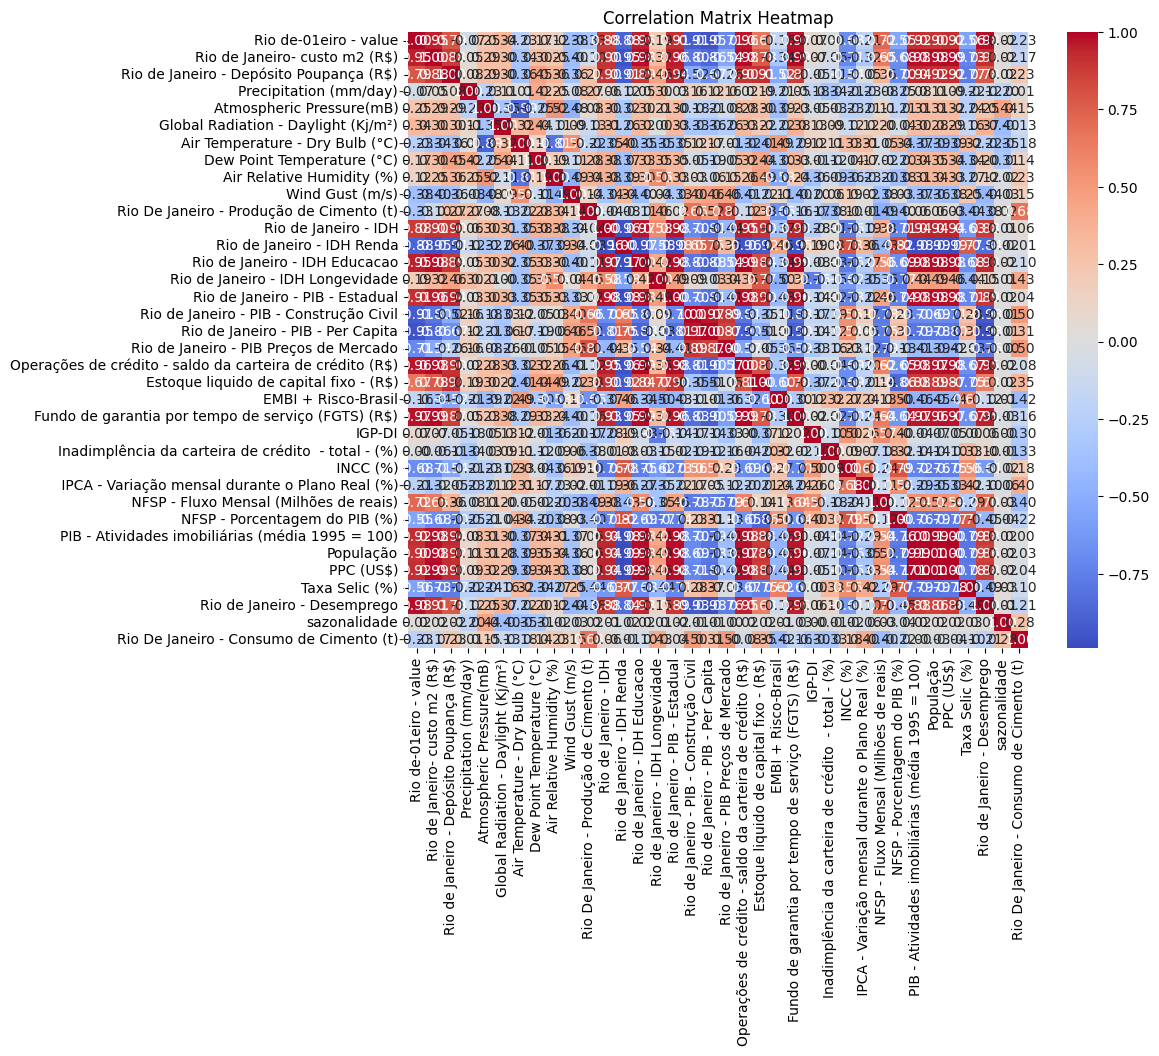

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio de-01eiro - value,7.544988e+03
1,Rio de Janeiro- custo m2 (R$),9.569038e+04
2,Rio de Janeiro - Depósito Poupança (R$),4.076697e+03
3,Precipitation (mm/day),5.039050e+00
4,Atmospheric Pressure(mB),3.558204e+01
5,Global Radiation - Daylight (Kj/m²),7.637171e+00
6,Air Temperature - Dry Bulb (°C),1.073228e+02
7,Dew Point Temperature (°C),2.401862e+01
8,Air Relative Humidity (%),4.752303e+01
9,Wind Gust (m/s),1.038174e+01


In [39]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' NFSP - Fluxo Mensal (Milhões de reais)',
                 'Air Temperature - Dry Bulb (°C)', 
                 'Dew Point Temperature (°C)',
                 'PPC (US$)',
                 'População',
                 'Rio de Janeiro- custo m2 (R$)',
                 'Rio de Janeiro - Depósito Poupança (R$)', 
                 'sazonalidade'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000000)
data

Num columns removed: 2


,Rio de-01eiro - value,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego,sazonalidade
0,0.291137,12454.864800,3.675288e+07,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.805095,0.731110,0.804160,3.583430e+08,1.813534e+07,22.143720,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.356512,281.787783
1,0.293538,12574.990185,3.674675e+07,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.804751,0.731248,0.804513,3.587441e+08,1.814108e+07,22.149228,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.350332,256.037383
2,0.295914,12687.426111,3.674063e+07,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.804407,0.731386,0.804866,3.591452e+08,1.814681e+07,22.154735,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.344152,297.774940
3,0.298264,12814.530039,3.673451e+07,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.804063,0.731524,0.805218,3.595464e+08,1.815255e+07,22.160243,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.337971,283.460373
4,0.300588,12915.463832,3.672839e+07,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.803719,0.731662,0.805571,3.599475e+08,1.815828e+07,22.165750,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.331791,302.478384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.459301,31395.170668,6.127016e+07,1.625707,1014.801014,1096.347300,21.422458,16.181642,74.665802,0.691213,223.273202,0.770312,0.761880,0.810260,4.067902e+08,1.742722e+07,21.881398,3.339533e+06,7.711687e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,12.511746,330.208811
200,0.461523,31637.091019,6.160980e+07,1.791286,1013.423886,1131.265478,22.017509,16.702321,74.492456,0.714184,223.018219,0.770285,0.761750,0.809852,4.063956e+08,1.743699e+07,21.880975,3.365687e+06,7.707969e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,12.507089,312.754725
201,0.463770,31882.823198,6.194943e+07,2.148690,1012.154763,1177.678304,22.777519,17.397303,74.358771,0.727686,223.333782,0.770259,0.761619,0.809444,4.060010e+08,1.744676e+07,21.880551,3.396904e+06,7.704251e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,2.007550e+08,439.156241,0.467083,12.502432,314.983179
202,0.466050,32144.9282

In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego
0,-1.594367,-1.443184,0.790581,-0.892209,2.055316,0.998314,1.283399,-0.043062,-3.612953,-1.076413,2.187374,-1.635403,-2.880146,-1.855153,0.216227,0.196392,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,-0.852702
1,-1.573055,-1.443798,0.212117,-0.301246,1.818915,0.558164,0.840277,-0.074442,-2.587411,-1.095295,2.155628,-1.623132,-2.800903,-1.832789,0.228585,0.226659,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,-0.855760
2,-1.553108,-1.444413,-0.208573,0.099855,0.732238,0.098867,0.565214,0.120926,-1.829593,-1.087606,2.123881,-1.610861,-2.721659,-1.810425,0.240944,0.256927,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,-0.858817
3,-1.530558,-1.445027,-0.382607,0.573481,0.440748,-0.242827,0.203260,0.085492,-1.249586,-1.088316,2.092135,-1.598591,-2.642416,-1.788061,0.253303,0.287194,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,-0.861875
4,-1.512652,-1.445641,-0.738290,1.080129,-0.252870,-0.706613,-0.259691,0.068258,-0.777178,-1.089491,2.060389,-1.586320,-2.563172,-1.765697,0.265662,0.317461,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,-0.864932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.765860,1.017099,-0.398469,1.064665,-0.655859,-0.865233,-0.733128,-0.488383,-0.917247,-0.197115,-1.021740,1.100314,-1.510371,0.845940,-1.309953,-1.245248,1.360064,0.117681,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.378950,1.402207,-1.370268,1.203059
200,1.808779,1.051181,-0.234871,0.433755,-0.317042,-0.608892,-0.515416,-0.513181,-0.766326,-0.206383,-1.024188,1.088724,-1.602022,0.823940,-1.288897,-1.247577,1.384545,0.092456,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.391539,1.410056,-1.390925,1.200755
201,1.852375,1.085263,0.118256,-0.147674,0.133309,-0.281489,-0.224824,-0.532305,-0.677610,-0.194913,-1.026636,1.077134,-1.693672,0.801940,-1.267840,-1.249906,1.413764,0.067231,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.404128,1.417346,-1.527663,1.198451
202,1.898875,1.119344,0.179332,-0.471012,-0.020279,-0.051083,0.086648,-0.384048,-0.698791,-0.190239,-1.029084,1.065544,-1.785323,0.779939,-1.246784,-1.252235,1.440408,0.042006,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.416717,1.423988,-1.609340,1.196147


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego
0,-1.594367,-1.443184,0.790581,-0.892209,2.055316,0.998314,1.283399,-0.043062,-3.612953,-1.076413,2.187374,-1.635403,-2.880146,-1.855153,0.216227,0.196392,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,-0.852702
1,-1.573055,-1.443798,0.212117,-0.301246,1.818915,0.558164,0.840277,-0.074442,-2.587411,-1.095295,2.155628,-1.623132,-2.800903,-1.832789,0.228585,0.226659,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,-0.855760
2,-1.553108,-1.444413,-0.208573,0.099855,0.732238,0.098867,0.565214,0.120926,-1.829593,-1.087606,2.123881,-1.610861,-2.721659,-1.810425,0.240944,0.256927,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,-0.858817
3,-1.530558,-1.445027,-0.382607,0.573481,0.440748,-0.242827,0.203260,0.085492,-1.249586,-1.088316,2.092135,-1.598591,-2.642416,-1.788061,0.253303,0.287194,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,-0.861875
4,-1.512652,-1.445641,-0.738290,1.080129,-0.252870,-0.706613,-0.259691,0.068258,-0.777178,-1.089491,2.060389,-1.586320,-2.563172,-1.765697,0.265662,0.317461,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,-0.864932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.427189,0.768206,-0.486946,0.777025,-0.786671,-0.600013,-0.471858,-0.502694,-0.643238,-0.475670,-1.047842,1.237655,-0.479934,1.061481,-1.503677,-1.220911,1.193119,0.391058,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.238976,1.279826,-1.152820,1.225944
188,1.446111,0.770271,-0.241933,0.229298,-0.187731,-0.259387,-0.223741,-0.630213,-0.460331,-0.459227,-1.039194,1.226413,-0.557711,1.049173,-1.494411,-1.222518,1.206925,0.371698,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.249345,1.291262,-1.253503,1.224593
189,1.465515,0.772335,0.082492,-0.068148,0.710000,0.131258,0.042576,-0.786580,-0.276224,-0.418457,-1.030546,1.215171,-0.635487,1.036865,-1.485145,-1.224124,1.227934,0.352338,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.259715,1.301919,-1.425444,1.223241
190,1.486346,0.774399,0.434269,-0.385341,1.426919,0.435768,0.232899,-0.944400,-0.049858,-0.398722,-1.021899,1.203929,-0.713263,1.024557,-1.475879,-1.225731,1.246115,0.332977,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.270085,1.311660,-1.237935,1.221890


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      246.602
1      237.093
2      270.163
3      263.941
4      273.825
        ...   
187    265.128
188    271.519
189    268.705
190    220.683
191    192.498
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 31)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego
156,0.930634,0.405480,0.454926,-0.676931,1.294286,0.705177,1.257302,0.378251,-0.342347,-1.365470,-1.254819,1.246501,1.431424,1.042068,-1.351846,-1.562818,1.222613,0.845472,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.903734,0.911463,0.407265,1.378193
157,0.948374,0.417238,0.344172,-0.295001,1.117927,0.503704,1.072791,0.384776,-0.502372,-1.444631,-1.247980,1.250895,1.381013,1.049177,-1.372523,-1.549199,1.211968,0.833972,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.914718,0.922870,0.137084,1.372540
158,0.965685,0.428997,-0.177623,0.307570,0.158335,-0.020315,0.683704,0.531135,-0.844549,-1.498301,-1.241140,1.255290,1.330602,1.056286,-1.393200,-1.535580,1.202030,0.822472,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.925702,0.935360,0.296087,1.366887
159,0.982428,0.440756,-0.560463,0.785807,-0.376025,-0.521874,0.189787,0.514734,-1.039727,-1.561599,-1.234301,1.259684,1.280190,1.063396,-1.413878,-1.521961,1.192181,0.810972,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.936687,0.948135,0.197300,1.361233
160,0.999471,0.452515,-0.620489,1.232927,-0.875985,-0.993182,-0.235694,0.543676,-1.035601,-1.639745,-1.227462,1.264078,1.229779,1.070505,-1.434555,-1.508342,1.183708,0.799472,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.947671,0.961143,0.469403,1.355580
161,1.016958,0.464274,-0.699301,1.419622,-0.901410,-1.173230,-0.458373,0.473559,-0.867243,-1.625551,-1.220622,1.268473,1.179367,1.077614,-1.455232,-1.494723,1.174004,0.787972,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.958655,0.973478,0.775434,1.349927
162,1.030278,0.476032,-0.847955,1.183422,-0.653320,-1.073253,-0.433548,0.366284,-0.525437,-1.621653,-1.213783,1.272867,1.128956,1.084724,-1.475910,-1.481103,1.166949,0.776472,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.969639,0.985778,0.136553,1.344273
163,1.043634,0.487791,-0.434657,0.819568,-0.336374,-0.907320,-0.286166,0.351531,-0.164636,-1.603781,-1.206944,1.277262,1.078545,1.091833,-1.496587,-1.467484,1.159632,0.764972,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.980624,0.999021,0.642038,1.338620
164,1.057846,0.499550,-0.173580,0.361558,0.194506,-0.585164,-0.002885,0.309495,0.068157,-1.592658,-1.200104,1.281656,1.028133,1.098942,-1.517264,-1.453865,1.154709,0.753473,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,0.991608,1.012408,0.482412,1.332967
165,1.072280,0.511309,0.449937,-0.170510,1.046358,-0.193585,0.326054,0.247712,0.300776,-1.570635,-1.193265,1.286050,0.977722,1.106051,-1.537942,-1.440246,1.151483,0.741973,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.002592,1.025524,0.367764,1.327313


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 31)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3329257571, 3553802665, 2834747440, 3533882060, 3905855310, 1340143677, 3241015593, 887554156, 2880067641, 2550168200]


Step: 0 ___________________________________________
val_loss: 1993.4566650390625
winner_seed: 3329257571


Step: 1 ___________________________________________
val_loss: 1730.1680908203125
winner_seed: 3553802665


Step: 2 ___________________________________________
val_loss: 1658.66845703125
winner_seed: 2834747440


Step: 3 ___________________________________________
val_loss: 1956.9534912109375


Step: 4 ___________________________________________
val_loss: 1819.32080078125


Step: 5 ___________________________________________
val_loss: 1668.4136962890625


Step: 6 ___________________________________________
val_loss: 1613.2421875
winner_seed: 3241015593


Step: 7 ___________________________________________
val_loss: 1838.6339111328125


Step: 8 ___________________________________________
val_loss: 2012.8770751953125


Step: 9 _____________________________________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 101ms/step - loss: 62946.1719 - val_loss: 7907.2402
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 6844.3853 - val_loss: 5771.0493
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 6723.7554 - val_loss: 10538.3857
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 6178.4121 - val_loss: 2536.3137
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 6415.0547 - val_loss: 4095.8975
Epoch 6/10000
5/5 [==============================] - 0s 10ms/step - loss: 6518.7583 - val_loss: 7073.3296
Epoch 7/10000
5/5 [==============================] - 0s 11ms/step - loss: 5282.2959 - val_loss: 3438.7290
Epoch 8/10000
5/5 [==============================] - 0s 11ms/step - loss: 5004.9790 - val_loss: 5235.0000
Epoch 9/10000
5/5 [==============================] - 0s 10ms/step - loss: 4535.5088 - val_loss: 5459.9561
Epoch 10/10000
5/5 [=======================

5/5 [==============================] - 0s 9ms/step - loss: 637.0526 - val_loss: 3023.0471
Epoch 79/10000
5/5 [==============================] - 0s 9ms/step - loss: 533.6595 - val_loss: 2475.5779
Epoch 80/10000
5/5 [==============================] - 0s 9ms/step - loss: 437.1046 - val_loss: 2641.8025
Epoch 81/10000
5/5 [==============================] - 0s 10ms/step - loss: 568.0165 - val_loss: 3141.6541
Epoch 82/10000
5/5 [==============================] - 0s 10ms/step - loss: 410.1169 - val_loss: 2473.3188
Epoch 83/10000
5/5 [==============================] - 0s 10ms/step - loss: 419.6042 - val_loss: 3276.8279
Epoch 84/10000
5/5 [==============================] - 0s 9ms/step - loss: 431.2051 - val_loss: 2624.0168
Epoch 85/10000
5/5 [==============================] - 0s 9ms/step - loss: 628.5181 - val_loss: 3501.2686
Epoch 86/10000
5/5 [==============================] - 0s 9ms/step - loss: 526.4124 - val_loss: 2578.6055
Epoch 87/10000
5/5 [==============================] - 0s 10ms/step 

5/5 [==============================] - 0s 11ms/step - loss: 319.8056 - val_loss: 2208.7866
Epoch 156/10000
5/5 [==============================] - 0s 11ms/step - loss: 317.2153 - val_loss: 2335.3853
Epoch 157/10000
5/5 [==============================] - 0s 10ms/step - loss: 338.2618 - val_loss: 2194.4019
Epoch 158/10000
5/5 [==============================] - 0s 11ms/step - loss: 283.0199 - val_loss: 2289.6238
Epoch 159/10000
5/5 [==============================] - 0s 10ms/step - loss: 281.4406 - val_loss: 2175.0657
Epoch 160/10000
5/5 [==============================] - 0s 9ms/step - loss: 312.5619 - val_loss: 2137.5686
Epoch 161/10000
5/5 [==============================] - 0s 10ms/step - loss: 292.0566 - val_loss: 2168.7673
Epoch 162/10000
5/5 [==============================] - 0s 10ms/step - loss: 300.0950 - val_loss: 2124.9976
Epoch 163/10000
5/5 [==============================] - 0s 10ms/step - loss: 305.7281 - val_loss: 2144.5159
Epoch 164/10000
5/5 [==============================] -

Epoch 232/10000
5/5 [==============================] - 0s 7ms/step - loss: 211.1442 - val_loss: 2117.3730
Epoch 233/10000
5/5 [==============================] - 0s 9ms/step - loss: 200.5699 - val_loss: 2171.0234
Epoch 234/10000
5/5 [==============================] - 0s 8ms/step - loss: 229.1673 - val_loss: 2073.0823
Epoch 235/10000
5/5 [==============================] - 0s 9ms/step - loss: 252.1678 - val_loss: 2149.8772
Epoch 236/10000
5/5 [==============================] - 0s 8ms/step - loss: 205.7319 - val_loss: 2123.1091
Epoch 237/10000
5/5 [==============================] - 0s 8ms/step - loss: 237.5034 - val_loss: 2136.3738
Epoch 238/10000
5/5 [==============================] - 0s 10ms/step - loss: 213.6276 - val_loss: 2165.9839
Epoch 239/10000
5/5 [==============================] - 0s 9ms/step - loss: 225.2042 - val_loss: 2037.0828
Epoch 240/10000
5/5 [==============================] - 0s 9ms/step - loss: 192.2467 - val_loss: 2191.4265
Epoch 241/10000
5/5 [========================

5/5 [==============================] - 0s 9ms/step - loss: 153.4998 - val_loss: 2050.9900
Epoch 310/10000
5/5 [==============================] - 0s 9ms/step - loss: 197.3779 - val_loss: 2062.7327
Epoch 311/10000
5/5 [==============================] - 0s 9ms/step - loss: 154.9057 - val_loss: 2098.1104
Epoch 312/10000
5/5 [==============================] - 0s 9ms/step - loss: 158.1069 - val_loss: 2231.7332
Epoch 313/10000
5/5 [==============================] - 0s 11ms/step - loss: 163.5630 - val_loss: 2280.7981
Epoch 314/10000
5/5 [==============================] - 0s 10ms/step - loss: 146.0794 - val_loss: 2110.7725
Epoch 315/10000
5/5 [==============================] - 0s 11ms/step - loss: 156.1544 - val_loss: 2171.1057
Epoch 316/10000
5/5 [==============================] - 0s 11ms/step - loss: 164.4300 - val_loss: 1941.2511
Epoch 317/10000
5/5 [==============================] - 0s 11ms/step - loss: 186.2003 - val_loss: 2312.5557
Epoch 318/10000
5/5 [==============================] - 0s

5/5 [==============================] - 0s 9ms/step - loss: 143.2181 - val_loss: 2240.2590
Epoch 387/10000
5/5 [==============================] - 0s 9ms/step - loss: 133.4777 - val_loss: 2179.4194
Epoch 388/10000
5/5 [==============================] - 0s 10ms/step - loss: 134.8665 - val_loss: 2214.4119
Epoch 389/10000
5/5 [==============================] - 0s 9ms/step - loss: 138.0373 - val_loss: 2201.0774
Epoch 390/10000
5/5 [==============================] - 0s 10ms/step - loss: 127.2710 - val_loss: 2091.6062
Epoch 391/10000
5/5 [==============================] - 0s 10ms/step - loss: 130.0887 - val_loss: 2223.9519
Epoch 392/10000
5/5 [==============================] - 0s 10ms/step - loss: 137.8238 - val_loss: 2062.4294
Epoch 393/10000
5/5 [==============================] - 0s 10ms/step - loss: 155.1833 - val_loss: 2304.5588
Epoch 394/10000
5/5 [==============================] - 0s 9ms/step - loss: 140.1215 - val_loss: 2176.0916
Epoch 395/10000
5/5 [==============================] - 0s

Epoch 463/10000
5/5 [==============================] - 0s 10ms/step - loss: 122.1969 - val_loss: 2133.8276
Epoch 464/10000
5/5 [==============================] - 0s 10ms/step - loss: 117.1374 - val_loss: 2208.6660
Epoch 465/10000
5/5 [==============================] - 0s 11ms/step - loss: 114.1385 - val_loss: 2116.7617
Epoch 466/10000
5/5 [==============================] - 0s 10ms/step - loss: 100.5943 - val_loss: 2116.7993
Epoch 467/10000
5/5 [==============================] - 0s 11ms/step - loss: 124.8722 - val_loss: 2121.6353
Epoch 468/10000
5/5 [==============================] - 0s 10ms/step - loss: 101.4861 - val_loss: 2081.6238
Epoch 469/10000
5/5 [==============================] - 0s 9ms/step - loss: 125.8011 - val_loss: 2103.2004
Epoch 470/10000
5/5 [==============================] - 0s 9ms/step - loss: 157.0584 - val_loss: 2292.8896
Epoch 471/10000
5/5 [==============================] - 0s 9ms/step - loss: 157.4278 - val_loss: 2418.9973
Epoch 472/10000
5/5 [===================

Epoch 540/10000
5/5 [==============================] - 0s 8ms/step - loss: 94.6515 - val_loss: 2141.9521
Epoch 541/10000
5/5 [==============================] - 0s 9ms/step - loss: 102.5378 - val_loss: 2109.8547
Epoch 542/10000
5/5 [==============================] - 0s 9ms/step - loss: 98.4718 - val_loss: 2125.9321
Epoch 543/10000
5/5 [==============================] - 0s 9ms/step - loss: 107.0302 - val_loss: 2387.3943
Epoch 544/10000
5/5 [==============================] - 0s 9ms/step - loss: 103.8318 - val_loss: 2132.0044
Epoch 545/10000
5/5 [==============================] - 0s 9ms/step - loss: 115.0075 - val_loss: 2226.3801
Epoch 546/10000
5/5 [==============================] - 0s 9ms/step - loss: 122.7794 - val_loss: 2080.6938
Epoch 547/10000
5/5 [==============================] - 0s 10ms/step - loss: 115.0544 - val_loss: 2177.1785
Epoch 548/10000
5/5 [==============================] - 0s 11ms/step - loss: 108.7154 - val_loss: 2146.2102
Epoch 549/10000
5/5 [=========================

5/5 [==============================] - 0s 10ms/step - loss: 87.0174 - val_loss: 2205.2915
Epoch 618/10000
5/5 [==============================] - 0s 9ms/step - loss: 97.1024 - val_loss: 2160.4272
Epoch 619/10000
5/5 [==============================] - 0s 10ms/step - loss: 85.7448 - val_loss: 2333.7861
Epoch 620/10000
5/5 [==============================] - 0s 10ms/step - loss: 88.0959 - val_loss: 2070.0295
Epoch 621/10000
5/5 [==============================] - 0s 10ms/step - loss: 98.1284 - val_loss: 2204.0791
Epoch 622/10000
5/5 [==============================] - 0s 10ms/step - loss: 83.9438 - val_loss: 2173.6567
Epoch 623/10000
5/5 [==============================] - 0s 10ms/step - loss: 89.8557 - val_loss: 2187.7842
Epoch 624/10000
5/5 [==============================] - 0s 10ms/step - loss: 88.7814 - val_loss: 2307.0837
Epoch 625/10000
5/5 [==============================] - 0s 9ms/step - loss: 92.9123 - val_loss: 2124.7622
Epoch 626/10000
5/5 [==============================] - 0s 10ms/s

5/5 [==============================] - 0s 9ms/step - loss: 85.2369 - val_loss: 2016.2313
Epoch 695/10000
5/5 [==============================] - 0s 9ms/step - loss: 89.7834 - val_loss: 2117.9314
Epoch 696/10000
5/5 [==============================] - 0s 9ms/step - loss: 84.2587 - val_loss: 2205.3174
Epoch 697/10000
5/5 [==============================] - 0s 9ms/step - loss: 78.4512 - val_loss: 2574.2703
Epoch 698/10000
5/5 [==============================] - 0s 9ms/step - loss: 102.0693 - val_loss: 2382.9395
Epoch 699/10000
5/5 [==============================] - 0s 10ms/step - loss: 89.1736 - val_loss: 2154.1208
Epoch 700/10000
5/5 [==============================] - 0s 9ms/step - loss: 89.9852 - val_loss: 2145.3601
Epoch 701/10000
5/5 [==============================] - 0s 10ms/step - loss: 97.7670 - val_loss: 2073.0161
Epoch 702/10000
5/5 [==============================] - 0s 10ms/step - loss: 96.1501 - val_loss: 2109.0032
Epoch 703/10000
5/5 [==============================] - 0s 10ms/step

Epoch 772/10000
5/5 [==============================] - 0s 9ms/step - loss: 74.2155 - val_loss: 2088.6528
Epoch 773/10000
5/5 [==============================] - 0s 9ms/step - loss: 80.6682 - val_loss: 2081.5737
Epoch 774/10000
5/5 [==============================] - 0s 9ms/step - loss: 86.9932 - val_loss: 2102.2085
Epoch 775/10000
5/5 [==============================] - 0s 9ms/step - loss: 75.4046 - val_loss: 2118.2380
Epoch 776/10000
5/5 [==============================] - 0s 8ms/step - loss: 86.4101 - val_loss: 2159.2805
Epoch 777/10000
5/5 [==============================] - 0s 8ms/step - loss: 72.7911 - val_loss: 2015.0265
Epoch 778/10000
5/5 [==============================] - 0s 8ms/step - loss: 76.9494 - val_loss: 2141.5862
Epoch 779/10000
5/5 [==============================] - 0s 9ms/step - loss: 73.3733 - val_loss: 2069.6396
Epoch 780/10000
5/5 [==============================] - 0s 9ms/step - loss: 69.1020 - val_loss: 2314.8142
Epoch 781/10000
5/5 [==============================] - 

5/5 [==============================] - 0s 10ms/step - loss: 75.4029 - val_loss: 2064.2529
Epoch 850/10000
5/5 [==============================] - 0s 10ms/step - loss: 72.4618 - val_loss: 2125.0342
Epoch 851/10000
5/5 [==============================] - 0s 9ms/step - loss: 63.2204 - val_loss: 2106.6528
Epoch 852/10000
5/5 [==============================] - 0s 9ms/step - loss: 64.0994 - val_loss: 2058.5229
Epoch 853/10000
5/5 [==============================] - 0s 9ms/step - loss: 70.4217 - val_loss: 2181.1172
Epoch 854/10000
5/5 [==============================] - 0s 9ms/step - loss: 69.5821 - val_loss: 2152.3684
Epoch 855/10000
5/5 [==============================] - 0s 9ms/step - loss: 78.3631 - val_loss: 2101.9106
Epoch 856/10000
5/5 [==============================] - 0s 10ms/step - loss: 72.6176 - val_loss: 2083.4529
Epoch 857/10000
5/5 [==============================] - 0s 11ms/step - loss: 69.3636 - val_loss: 2119.9312
Epoch 858/10000
5/5 [==============================] - 0s 11ms/step

5/5 [==============================] - 0s 9ms/step - loss: 68.4086 - val_loss: 2238.7346
Epoch 927/10000
5/5 [==============================] - 0s 10ms/step - loss: 68.1811 - val_loss: 2146.7961
Epoch 928/10000
5/5 [==============================] - 0s 9ms/step - loss: 72.0916 - val_loss: 2184.8462
Epoch 929/10000
5/5 [==============================] - 0s 10ms/step - loss: 69.2098 - val_loss: 2094.5142
Epoch 930/10000
5/5 [==============================] - 0s 10ms/step - loss: 69.1081 - val_loss: 2148.3450
Epoch 931/10000
5/5 [==============================] - 0s 10ms/step - loss: 77.4982 - val_loss: 2087.9656
Epoch 932/10000
5/5 [==============================] - 0s 10ms/step - loss: 69.1471 - val_loss: 2100.9236
Epoch 933/10000
5/5 [==============================] - 0s 9ms/step - loss: 79.1341 - val_loss: 2278.5547
Epoch 934/10000
5/5 [==============================] - 0s 10ms/step - loss: 70.8565 - val_loss: 2235.4675
Epoch 935/10000
5/5 [==============================] - 0s 10ms/st

Epoch 1004/10000
5/5 [==============================] - 0s 10ms/step - loss: 58.3701 - val_loss: 2103.4390
Epoch 1005/10000
5/5 [==============================] - 0s 10ms/step - loss: 63.0269 - val_loss: 2158.7949
Epoch 1006/10000
5/5 [==============================] - 0s 9ms/step - loss: 71.5883 - val_loss: 2117.8257
Epoch 1007/10000
5/5 [==============================] - 0s 10ms/step - loss: 68.8310 - val_loss: 2131.8462
Epoch 1008/10000
5/5 [==============================] - 0s 9ms/step - loss: 62.7736 - val_loss: 2266.9097
Epoch 1009/10000
5/5 [==============================] - 0s 9ms/step - loss: 61.7028 - val_loss: 2087.6628
Epoch 1010/10000
5/5 [==============================] - 0s 10ms/step - loss: 69.9297 - val_loss: 2191.5637
Epoch 1011/10000
5/5 [==============================] - 0s 8ms/step - loss: 60.6596 - val_loss: 2178.8198
Epoch 1012/10000
5/5 [==============================] - 0s 8ms/step - loss: 64.5640 - val_loss: 2145.7288
Epoch 1013/10000
5/5 [====================

Epoch 1081/10000
5/5 [==============================] - 0s 11ms/step - loss: 56.3357 - val_loss: 2117.1169
Epoch 1082/10000
5/5 [==============================] - 0s 10ms/step - loss: 55.8350 - val_loss: 1994.9897
Epoch 1083/10000
5/5 [==============================] - 0s 11ms/step - loss: 60.3726 - val_loss: 1983.3511
Epoch 1084/10000
5/5 [==============================] - 0s 9ms/step - loss: 61.3406 - val_loss: 2109.1567
Epoch 1085/10000
5/5 [==============================] - 0s 10ms/step - loss: 58.1102 - val_loss: 2155.8279
Epoch 1086/10000
5/5 [==============================] - 0s 10ms/step - loss: 55.2161 - val_loss: 2098.5283
Epoch 1087/10000
5/5 [==============================] - 0s 10ms/step - loss: 51.9432 - val_loss: 1983.8615
Epoch 1088/10000
5/5 [==============================] - 0s 10ms/step - loss: 63.3290 - val_loss: 2220.4592
Epoch 1089/10000
5/5 [==============================] - 0s 10ms/step - loss: 57.0951 - val_loss: 2121.0015
Epoch 1090/10000
5/5 [================

Epoch 1158/10000
5/5 [==============================] - 0s 10ms/step - loss: 53.6665 - val_loss: 1824.7677
Epoch 1159/10000
5/5 [==============================] - 0s 9ms/step - loss: 52.4359 - val_loss: 1927.1543
Epoch 1160/10000
5/5 [==============================] - 0s 10ms/step - loss: 59.3776 - val_loss: 1859.3993
Epoch 1161/10000
5/5 [==============================] - 0s 10ms/step - loss: 58.9373 - val_loss: 1872.8290
Epoch 1162/10000
5/5 [==============================] - 0s 9ms/step - loss: 57.7922 - val_loss: 1831.4020
Epoch 1163/10000
5/5 [==============================] - 0s 9ms/step - loss: 51.7491 - val_loss: 1871.6656
Epoch 1164/10000
5/5 [==============================] - 0s 9ms/step - loss: 50.3668 - val_loss: 1861.7251
Epoch 1165/10000
5/5 [==============================] - 0s 10ms/step - loss: 50.7421 - val_loss: 1805.6144
Epoch 1166/10000
5/5 [==============================] - 0s 10ms/step - loss: 57.1373 - val_loss: 1940.2577
Epoch 1167/10000
5/5 [===================

5/5 [==============================] - 0s 9ms/step - loss: 213.5082 - val_loss: 1931.9341
Epoch 1235/10000
5/5 [==============================] - 0s 10ms/step - loss: 246.1693 - val_loss: 1969.0640
Epoch 1236/10000
5/5 [==============================] - 0s 11ms/step - loss: 291.2265 - val_loss: 2043.0360
Epoch 1237/10000
5/5 [==============================] - 0s 10ms/step - loss: 234.1211 - val_loss: 2181.2815
Epoch 1238/10000
5/5 [==============================] - 0s 11ms/step - loss: 201.8289 - val_loss: 1946.3204
Epoch 1239/10000
5/5 [==============================] - 0s 11ms/step - loss: 196.9304 - val_loss: 1981.2114
Epoch 1240/10000
5/5 [==============================] - 0s 10ms/step - loss: 170.0059 - val_loss: 1976.1421
Epoch 1241/10000
5/5 [==============================] - 0s 9ms/step - loss: 167.4843 - val_loss: 1982.4872
Epoch 1242/10000
5/5 [==============================] - 0s 9ms/step - loss: 201.2650 - val_loss: 2028.5314
Epoch 1243/10000
5/5 [==========================

5/5 [==============================] - 0s 11ms/step - loss: 133.7301 - val_loss: 1929.8722
Epoch 1311/10000
5/5 [==============================] - 0s 11ms/step - loss: 141.1152 - val_loss: 1872.8866
Epoch 1312/10000
5/5 [==============================] - 0s 10ms/step - loss: 126.7019 - val_loss: 1919.1366
Epoch 1313/10000
5/5 [==============================] - 0s 10ms/step - loss: 135.8627 - val_loss: 2040.0454
Epoch 1314/10000
5/5 [==============================] - 0s 10ms/step - loss: 132.6142 - val_loss: 1915.9181
Epoch 1315/10000
5/5 [==============================] - 0s 10ms/step - loss: 135.4760 - val_loss: 1946.2216
Epoch 1316/10000
5/5 [==============================] - 0s 10ms/step - loss: 127.4680 - val_loss: 1894.2266
Epoch 1317/10000
5/5 [==============================] - 0s 9ms/step - loss: 126.8030 - val_loss: 2002.8267
Epoch 1318/10000
5/5 [==============================] - 0s 9ms/step - loss: 117.7412 - val_loss: 2047.0012
Epoch 1319/10000
5/5 [=========================

5/5 [==============================] - 0s 10ms/step - loss: 123.0902 - val_loss: 2260.1284
Epoch 1387/10000
5/5 [==============================] - 0s 11ms/step - loss: 120.6515 - val_loss: 1874.5266
Epoch 1388/10000
5/5 [==============================] - 0s 10ms/step - loss: 117.6078 - val_loss: 1994.0682
Epoch 1389/10000
5/5 [==============================] - 0s 11ms/step - loss: 121.1587 - val_loss: 1947.7942
Epoch 1390/10000
5/5 [==============================] - 0s 10ms/step - loss: 105.6162 - val_loss: 2127.7336
Epoch 1391/10000
5/5 [==============================] - 0s 10ms/step - loss: 153.6896 - val_loss: 1905.4786
Epoch 1392/10000
5/5 [==============================] - 0s 9ms/step - loss: 115.0847 - val_loss: 1907.1440
Epoch 1393/10000
5/5 [==============================] - 0s 9ms/step - loss: 118.2790 - val_loss: 1843.8921
Epoch 1394/10000
5/5 [==============================] - 0s 9ms/step - loss: 109.6978 - val_loss: 2017.5055
Epoch 1395/10000
5/5 [==========================

5/5 [==============================] - 0s 10ms/step - loss: 110.2393 - val_loss: 2064.9573
Epoch 1463/10000
5/5 [==============================] - 0s 9ms/step - loss: 96.7323 - val_loss: 1924.7316
Epoch 1464/10000
5/5 [==============================] - 0s 9ms/step - loss: 109.9305 - val_loss: 1868.4376
Epoch 1465/10000
5/5 [==============================] - 0s 9ms/step - loss: 102.0070 - val_loss: 1836.8267
Epoch 1466/10000
5/5 [==============================] - 0s 10ms/step - loss: 94.3891 - val_loss: 1888.6992
Epoch 1467/10000
5/5 [==============================] - 0s 9ms/step - loss: 97.4472 - val_loss: 1931.3257
Epoch 1468/10000
5/5 [==============================] - 0s 10ms/step - loss: 115.5516 - val_loss: 1853.7312
Epoch 1469/10000
5/5 [==============================] - 0s 10ms/step - loss: 94.1930 - val_loss: 1903.6383
Epoch 1470/10000
5/5 [==============================] - 0s 9ms/step - loss: 106.5198 - val_loss: 1815.2655
Epoch 1471/10000
5/5 [==============================] 

5/5 [==============================] - 0s 7ms/step - loss: 95.7141 - val_loss: 1884.1154
Epoch 1540/10000
5/5 [==============================] - 0s 7ms/step - loss: 104.1975 - val_loss: 1809.2056
Epoch 1541/10000
5/5 [==============================] - 0s 7ms/step - loss: 86.4946 - val_loss: 1827.6348
Epoch 1542/10000
5/5 [==============================] - 0s 8ms/step - loss: 87.1727 - val_loss: 1929.4343
Epoch 1543/10000
5/5 [==============================] - 0s 8ms/step - loss: 92.2546 - val_loss: 1765.4972
Epoch 1544/10000
5/5 [==============================] - 0s 8ms/step - loss: 85.2677 - val_loss: 1788.0968
Epoch 1545/10000
5/5 [==============================] - 0s 8ms/step - loss: 85.6532 - val_loss: 1924.3296
Epoch 1546/10000
5/5 [==============================] - 0s 8ms/step - loss: 91.5222 - val_loss: 2170.2444
Epoch 1547/10000
5/5 [==============================] - 0s 8ms/step - loss: 99.3952 - val_loss: 2024.3926
Epoch 1548/10000
5/5 [==============================] - 0s 9ms

5/5 [==============================] - 0s 9ms/step - loss: 88.1629 - val_loss: 1735.5378
Epoch 1617/10000
5/5 [==============================] - 0s 8ms/step - loss: 82.1243 - val_loss: 1790.5730
Epoch 1618/10000
5/5 [==============================] - 0s 8ms/step - loss: 90.5814 - val_loss: 1776.7715
Epoch 1619/10000
5/5 [==============================] - 0s 7ms/step - loss: 99.0119 - val_loss: 1710.8573
Epoch 1620/10000
5/5 [==============================] - 0s 8ms/step - loss: 114.5953 - val_loss: 1798.8898
Epoch 1621/10000
5/5 [==============================] - 0s 8ms/step - loss: 87.0383 - val_loss: 1779.8927
Epoch 1622/10000
5/5 [==============================] - 0s 9ms/step - loss: 85.3788 - val_loss: 1760.5363
Epoch 1623/10000
5/5 [==============================] - 0s 8ms/step - loss: 83.5340 - val_loss: 1875.0161
Epoch 1624/10000
5/5 [==============================] - 0s 9ms/step - loss: 80.5732 - val_loss: 1895.5726
Epoch 1625/10000
5/5 [==============================] - 0s 9ms

5/5 [==============================] - 0s 8ms/step - loss: 78.4176 - val_loss: 1919.3481
Epoch 1694/10000
5/5 [==============================] - 0s 8ms/step - loss: 89.4910 - val_loss: 1931.6136
Epoch 1695/10000
5/5 [==============================] - 0s 8ms/step - loss: 72.2466 - val_loss: 1790.9945
Epoch 1696/10000
5/5 [==============================] - 0s 8ms/step - loss: 70.6122 - val_loss: 1754.8358
Epoch 1697/10000
5/5 [==============================] - 0s 7ms/step - loss: 73.5079 - val_loss: 1780.4731
Epoch 1698/10000
5/5 [==============================] - 0s 7ms/step - loss: 78.9991 - val_loss: 1832.4567
Epoch 1699/10000
5/5 [==============================] - 0s 7ms/step - loss: 85.0158 - val_loss: 1829.3042
Epoch 1700/10000
5/5 [==============================] - 0s 8ms/step - loss: 75.9756 - val_loss: 1877.2356
Epoch 1701/10000
5/5 [==============================] - 0s 8ms/step - loss: 78.6619 - val_loss: 1766.7228
Epoch 1702/10000
5/5 [==============================] - 0s 8ms/

5/5 [==============================] - 0s 7ms/step - loss: 65.0442 - val_loss: 1758.1112
Epoch 1771/10000
5/5 [==============================] - 0s 7ms/step - loss: 73.7050 - val_loss: 1741.9064
Epoch 1772/10000
5/5 [==============================] - 0s 8ms/step - loss: 64.3880 - val_loss: 1758.1106
Epoch 1773/10000
5/5 [==============================] - 0s 8ms/step - loss: 71.6017 - val_loss: 1765.0923
Epoch 1774/10000
5/5 [==============================] - 0s 8ms/step - loss: 66.3300 - val_loss: 1804.4031
Epoch 1775/10000
5/5 [==============================] - 0s 7ms/step - loss: 72.6920 - val_loss: 1799.3676
Epoch 1776/10000
5/5 [==============================] - 0s 8ms/step - loss: 66.5158 - val_loss: 1761.8773
Epoch 1777/10000
5/5 [==============================] - 0s 8ms/step - loss: 65.8593 - val_loss: 1728.1113
Epoch 1778/10000
5/5 [==============================] - 0s 7ms/step - loss: 63.2406 - val_loss: 1770.7905
Epoch 1779/10000
5/5 [==============================] - 0s 8ms/

5/5 [==============================] - 0s 8ms/step - loss: 62.3108 - val_loss: 1788.8934
Epoch 1848/10000
5/5 [==============================] - 0s 8ms/step - loss: 72.2210 - val_loss: 1771.8496
Epoch 1849/10000
5/5 [==============================] - 0s 8ms/step - loss: 74.0323 - val_loss: 1816.0293
Epoch 1850/10000
5/5 [==============================] - 0s 11ms/step - loss: 60.9975 - val_loss: 1809.1602
Epoch 1851/10000
5/5 [==============================] - 0s 8ms/step - loss: 61.2138 - val_loss: 1832.1066
Epoch 1852/10000
5/5 [==============================] - 0s 7ms/step - loss: 58.6752 - val_loss: 1774.8221
Epoch 1853/10000
5/5 [==============================] - 0s 8ms/step - loss: 59.8941 - val_loss: 1740.9686
Epoch 1854/10000
5/5 [==============================] - 0s 7ms/step - loss: 62.8524 - val_loss: 1775.1809
Epoch 1855/10000
5/5 [==============================] - 0s 8ms/step - loss: 59.4291 - val_loss: 1792.6268
Epoch 1856/10000
5/5 [==============================] - 0s 8ms

5/5 [==============================] - 0s 8ms/step - loss: 65.5622 - val_loss: 1659.7417
Epoch 1925/10000
5/5 [==============================] - 0s 8ms/step - loss: 59.2781 - val_loss: 1723.6515
Epoch 1926/10000
5/5 [==============================] - 0s 8ms/step - loss: 58.6535 - val_loss: 1707.4325
Epoch 1927/10000
5/5 [==============================] - 0s 8ms/step - loss: 53.6609 - val_loss: 1705.4011
Epoch 1928/10000
5/5 [==============================] - 0s 8ms/step - loss: 72.0873 - val_loss: 1813.9862
Epoch 1929/10000
5/5 [==============================] - 0s 10ms/step - loss: 69.3562 - val_loss: 1775.4689
Epoch 1930/10000
5/5 [==============================] - 0s 8ms/step - loss: 62.7960 - val_loss: 1864.9364
Epoch 1931/10000
5/5 [==============================] - 0s 8ms/step - loss: 66.8085 - val_loss: 1861.5925
Epoch 1932/10000
5/5 [==============================] - 0s 8ms/step - loss: 66.0746 - val_loss: 1711.7601
Epoch 1933/10000
5/5 [==============================] - 0s 8ms

5/5 [==============================] - 0s 8ms/step - loss: 53.5610 - val_loss: 1803.7765
Epoch 2002/10000
5/5 [==============================] - 0s 8ms/step - loss: 53.3558 - val_loss: 1829.4650
Epoch 2003/10000
5/5 [==============================] - 0s 9ms/step - loss: 52.9085 - val_loss: 1772.6173
Epoch 2004/10000
5/5 [==============================] - 0s 9ms/step - loss: 51.2989 - val_loss: 1872.7040
Epoch 2005/10000
5/5 [==============================] - 0s 8ms/step - loss: 52.8799 - val_loss: 1872.8981
Epoch 2006/10000
5/5 [==============================] - 0s 8ms/step - loss: 56.5456 - val_loss: 1849.1903
Epoch 2007/10000
5/5 [==============================] - 0s 7ms/step - loss: 66.4992 - val_loss: 1729.3610
Epoch 2008/10000
5/5 [==============================] - 0s 7ms/step - loss: 53.2115 - val_loss: 1809.6021
Epoch 2009/10000
5/5 [==============================] - 0s 7ms/step - loss: 48.6539 - val_loss: 1760.5911
Epoch 2010/10000
5/5 [==============================] - 0s 6ms/

5/5 [==============================] - 0s 8ms/step - loss: 53.7929 - val_loss: 1819.2277
Epoch 2079/10000
5/5 [==============================] - 0s 8ms/step - loss: 52.4481 - val_loss: 1856.8947
Epoch 2080/10000
5/5 [==============================] - 0s 7ms/step - loss: 49.4548 - val_loss: 1866.3894
Epoch 2081/10000
5/5 [==============================] - 0s 8ms/step - loss: 50.8495 - val_loss: 1793.2618
Epoch 2082/10000
5/5 [==============================] - 0s 7ms/step - loss: 53.0144 - val_loss: 1812.0265
Epoch 2083/10000
5/5 [==============================] - 0s 8ms/step - loss: 51.5855 - val_loss: 1791.4100
Epoch 2084/10000
5/5 [==============================] - 0s 8ms/step - loss: 52.6342 - val_loss: 1781.5669
Epoch 2085/10000
5/5 [==============================] - 0s 7ms/step - loss: 55.5147 - val_loss: 1794.7047
Epoch 2086/10000
5/5 [==============================] - 0s 7ms/step - loss: 49.0980 - val_loss: 1748.3380
Epoch 2087/10000
5/5 [==============================] - 0s 7ms/

5/5 [==============================] - 0s 7ms/step - loss: 45.6083 - val_loss: 1737.6477
Epoch 2156/10000
5/5 [==============================] - 0s 7ms/step - loss: 46.0658 - val_loss: 1742.3423
Epoch 2157/10000
5/5 [==============================] - 0s 7ms/step - loss: 45.9762 - val_loss: 1815.1753
Epoch 2158/10000
5/5 [==============================] - 0s 8ms/step - loss: 44.6640 - val_loss: 1830.9153
Epoch 2159/10000
5/5 [==============================] - 0s 7ms/step - loss: 45.4204 - val_loss: 1819.0477
Epoch 2160/10000
5/5 [==============================] - 0s 8ms/step - loss: 46.1505 - val_loss: 1864.0508
Epoch 2161/10000
5/5 [==============================] - 0s 8ms/step - loss: 46.8213 - val_loss: 1718.3651
Epoch 2162/10000
5/5 [==============================] - 0s 7ms/step - loss: 47.2400 - val_loss: 1760.1859
Epoch 2163/10000
5/5 [==============================] - 0s 8ms/step - loss: 47.2665 - val_loss: 1780.0015
Epoch 2164/10000
5/5 [==============================] - 0s 7ms/

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,230.111435,232.650131,224.714737,222.791489,219.687836,245.601242,249.782318,250.782639,250.940796,252.206375,240.397491,241.798035
Target,228.07,212.958,252.909,237.46,235.758,251.783,273.551,253.127,248.124,206.532,226.668,202.742
Error,2.041428,19.692139,28.19426,14.668518,16.07016,6.181763,23.768677,2.34436,2.816803,45.674377,13.729492,39.05603


In [54]:
display(mae)
display(mape)

17.853167

0.07910427

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[2861.4644]] - Target[2829.6820000000002]| =  Error: [[31.78247]]; MAPE:[[0.01123182]]


[array([[31.78247]], dtype=float32)]

31.78247

0.011231817